# ELEC3305 Lab Project - Time Domain Sonar Lab


In this lab, we will interact with physical time-domain signals. We will use the chirp signal to characterize the response of the speaker-microphone system and look at detecting signals using cross-correlation.
In the second part, we will build on part one and use the speaker-microphone system to develop a simple sonar.


In [1]:
# Import functions and libraries
import numpy as np, matplotlib.pyplot as plt
import threading,time, queue, pyaudio 
from matplotlib.pyplot import *
import matplotlib.cm as cm
from scipy import signal
from threading import Lock


%matplotlib inline

## Part 1: Chirping!

When playing a sound and recording, the signal goes through several systems. In particular it goes through the response of the soundcard output, the speaker, the room we are in and the response of the microphone and receive part of the USB soundcard.

A chirp is a a signal in which the frequency increases linearly with time. In this assignment we will generate a chirp signal and use it to measure the amplitude of the frequency response of our speaker-room-microphone system. This lab will work best in a quiet environment -- We recommend that you execute the lab at home or in a quiet place before submitting it. 

A simultaneous frequency is defined as the derivative of the phase of a signal, $f = \frac{1}{2\pi} \frac{d\phi (t)}{ dt} $. For example, the simultaneous frequency of $\cos(\phi(t))=\cos(2\pi f_0 t)$ is  

$$f = \frac{d\phi (t)}{2\pi dt}  = f_0$$ 


For a linear chirp, the frequency changes linearly over time. The simultaneous frequency is therefore defined as 

<center>$$ f(t) = f_0 + kt. $$</center>


So,  

<center>$$ x(t) = \sin(2\pi\int_0^t f(t')dt') = \sin(2\pi\int_o^t(f_0+kt')dt') = \sin(2\pi(f_0+\frac{k}{2}t)t) $$</center>


### Part I Task I: Generating the Chirp

Generate a 10 seconds long chirp signal, sampled at 48,000[Hz] with a frequency range of 20[Hz] to 20,000[Hz]. Set the magnitude of the chirp to 0.5. This will help prevent non-linearities when we play the sound later. 

* Given $T$=total time length, $f_0$=start frequency, $f_1$ = end frequency, derive a formula $f(t)$ for the frequency sweep. Write the formula here:
$f(t) = f_0 + \frac{f_1-f_0}{T} t$

* Find the formula for the phase by integrating $\phi(t) = \int_0^T f(t)dt$ to get the phase function. Write the formula here:$\phi(t) = 2\pi(f_0 t+\frac{1}{2} k t^2)=2\pi(f_0 t+\frac{1}{2} \frac{f_1-f_0}{T} t^2)$


Now, 
* Set the sample-rate frequency `fs = 48000` Hz
* Generate a time index from `t=0` to `t=10` with sampling rate of 48000 Hz
* Generate a vector of frequency vs time: `phi_of_t`  (  $\phi(t)$ )
* Generate the chirp function `s_chirp` with amplitude of 0.5 by plugging the phase into a sinusoid. 
  
  


In [2]:
fs = 48000
f0 = 20
f1 = 20000
T = 10
# generate time index and phase
t = np.r_[0:10:(1/fs)]
k = (f1-f0)/T
phi_of_t = 2*np.pi*t*(f0+(k/2)*t)
# generate chirp signal
s_chirp = 0.5*np.sin(phi_of_t)

* Plot the first $\frac{1}{2}$ second of the chirp (`s_chirp`), you will notice that the carrier frequency increases and that the chirp has a constant envelope. To get a nice figure, make sure the aspect ratio of the figure is height/width = 0.2 . Label the axis and figure appropriately. 

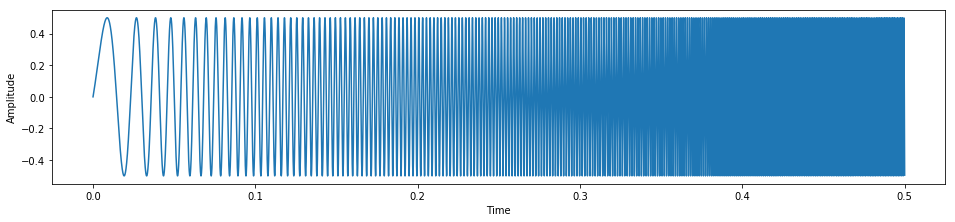

In [3]:
# Set the aspect ratio such that the image is wide
fs = 48000
f0 = 20
f1 = 20000
T = 10
# generate time index and phase
t=np.r_[0:0.5:(1/fs)]
k = (f1-f0)/T
f = f0+k*t
phi_of_t = 2*np.pi*t*(f0+(k/2)*t)
# generate chirp signal
s_chirp = 0.5*np.sin(phi_of_t)
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot(t,s_chirp)

plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

* Plot the magnitude frequency response of the sequence from 0 to $\pi$ using the function `signal.freqz`. Note, that the digital frequency range represents a physical frequency range of 0[hz] to 24000[Hz]. To get a nice figure, make sure the aspect ratio of the figure is height/width = 0.2. Label the axis and figure appropriately. 

The `signal.freqz` function can be slow -- be patient. 

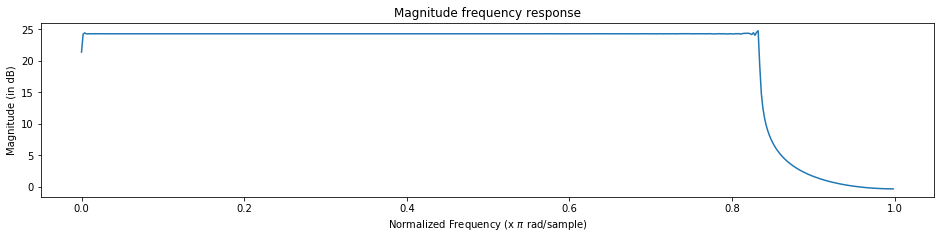

In [42]:
fs = 48000
f0 = 20
f1 = 20000
T = 10
# generate time index and phase
t = np.r_[0:10:(1/fs)]
k = (f1-f0)/T
f = f0+k*t
phi_of_t = 2*np.pi*t*(f0+(k/2)*t)
# generate chirp signal
s_chirp = 0.5*np.sin(phi_of_t)
# # generate frequency response of chirp
w,h = signal.freqz(s_chirp)
# generate frequency index
w = w/np.pi
# plot
width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(w, 10*np.log10(abs(h)))
plt.title('Magnitude frequency response')
plt.xlabel(r'Normalized Frequency (x $\pi$ rad/sample)')
plt.ylabel('Magnitude (in dB)')
plt.show()

Explain why the chirp is an appropriate signal to measure the magnitude frequency response of a system. 


#### Your answer here:

From its frequency response, we see that the chirp's magnitude starts reducing at 20kHz until 24kHz (frequencies humans can't hear) while being constant at around 49dB from 20Hz to 20kHz. The chirp is therefore an appropriate signal to measure the magnitude frequency response of a system.

### Part I Task II: Playing and Recording the Chirp
Now, we will play the sound of the chirp on our computer speaker and simultaneously record using the microphone. 

* On Apple computers it is recommended that you turn off the ambient noise reduction by going to system-preferences, selecting sound, choose the input tab and make sure that the "Use ambient noise reduction" box is unchecked. In some windows system there's ambient noise reduction as well. Make sure it is also turned off. 

* Your laptop most likely has two speakers. It is best if we work only with one. Go to the operating system's sound settings and change the stereo settings such that the speaker that is closest to the microphone is active. Your result will be much better that way. 
		
* Make sure your output volume is at 70-80% and that the laptop's microphone is on, again to avoid non-linear distorsions. 

* We will record 12 seconds just to make sure we capture the entire sequence. 

The code below defines some functions to use with pyaudio -- a multi-platform audio python interface. 

In [7]:
def play_audio( Q, p, fs , dev=None):
    # play_audio plays audio with sampling rate = fs
    # Q - A queue object from which to play
    # p   - pyAudio object
    # fs  - sampling rate
    # dev - device number
    
    # Example:
    # fs = 44100
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # Q = Queue.queue()
    # Q.put(data)
    # Q.put("EOT") # when function gets EOT it will quit
    # play_audio( Q, p, fs,1 ) # play audio
    # p.terminate() # terminate pyAudio
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),output=True,output_device_index=dev)
    # play audio
    while (1):
        data = Q.get()
        if data is "EOT" :
            break
        try:
            ostream.write( data.astype(np.float32).tostring() )
        except:
            break
            
def record_audio( queue, p, fs ,dev=None,chunk=2048,lock=None):
    # record_audio records audio with sampling rate = fs
    # queue - output data queue
    # p     - pyAudio object
    # fs    - sampling rate
    # dev   - device number
    # chunk - chunks of samples at a time default 1024
    #
    # Example:
    # fs = 44100
    # Q = Queue.queue()
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # record_audio( Q, p, fs, 1) #
    # p.terminate() # terminate pyAudio
    
    istream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),input=True,input_device_index=dev,frames_per_buffer=chunk)

    # record audio in chunks and append to frames
    frames = [];
    while (1):
        try:  # when the pyaudio object is destroyed, stops
            with lock if lock is not None else 1:
                data_str = istream.read(chunk, exception_on_overflow=False) # read a chunk of data
        except:
            break
        data_flt = np.fromstring( data_str, 'float32' ) # convert string to float
        queue.put( data_flt ) # append to list

def xciever(sig, fs):
    # function takes a signal and a sampling frequency
    # it then plays and records at the same time. The function returns
    # the recorded sound.

    rcv = [];

    # create an input output FIFO queues
    Qin = queue.Queue()
    Qout = queue.Queue()

    #lock for controlling access to shared resources
    lock = Lock()
    
    # create a pyaudio object
    p = pyaudio.PyAudio()

    # initialize a recording thread.
    t_rec = threading.Thread(target = record_audio,   args = (Qin, p, fs ), kwargs={'lock': lock})
    t_play_audio = threading.Thread(target = play_audio,  args = (Qout, p, fs  ))

    # start the recording and playing threads
    t_rec.start()
    t_play_audio.start()

    Qout.put( sig );
    Qout.put( "EOT" );

    # pause for RECORD_SECS seconds
    RECORD_SECS = len(sig)/fs + 2.0
    time.sleep( RECORD_SECS )
    # terminate pyAudio
    with lock:
        p.terminate()
        
    # append to output
    while ( not Qin.empty()) :
        data = Qin.get()
        rcv = np.append( rcv, data )

    return rcv

__Playing and recording audio:__

* Run the following code. It is an example of how to play and record sound at the same time and uses threading for the play and record threads.

The resulting received sequence will be stored in the variable `rcv_chirp`.

In [43]:
## Play and record chirp at the same time

fs = 48000 # sampling rate = 48000 Hz

rcv_chirp = xciever(s_chirp, fs) # Qin = queue.Queue() Qout = queue.Queue() / Note: queue instead of Queue for python3


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


* Plot the frequency response of the received sequence. 
* Also, plot the absolute value of the received signal. Plotting the absolute value (sort of) displays the envelope of the chirp. 

Label the figures and use an aspect ratio of Height/Width = 0.2


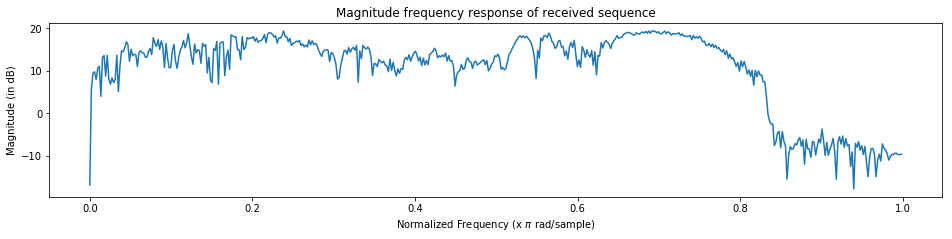

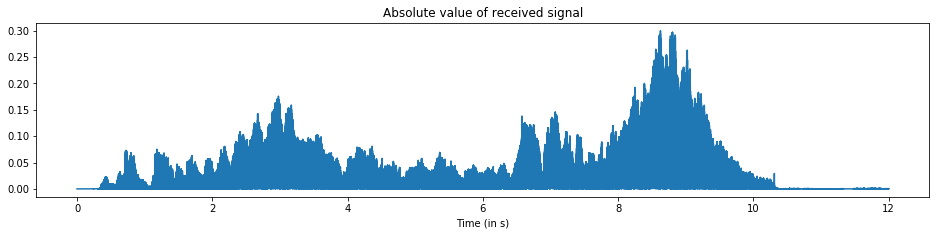

In [9]:
## Plot chirp response

size = np.shape(rcv_chirp)
samples = size[0];

# generate frequency response of recorded chirp
w,h = signal.freqz(rcv_chirp)

# generate frequency index
w = w/np.pi

# generate a time index
t = np.linspace(0,12,num=samples)
# plot
width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(w, 10*np.log10(abs(h)))
plt.title('Magnitude frequency response of received sequence')
plt.xlabel(r'Normalized Frequency (x $\pi$ rad/sample)')
plt.ylabel('Magnitude (in dB)')
plt.show()

# plot
width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(t, abs(rcv_chirp))
plt.title('Absolute value of received signal')
plt.xlabel('Time (in s)')
plt.show()


* Comment on the results you got. In addition, what is the implicit assumption we are making in order to claim that the result is a frequency response? 
(HINT: consider the case when the chirp was very short)


#### Answers here:

We see that the structure of the system's frequency response resembles very much the chirp signal's response and envelope. However, the magnitude is not constant between 20Hz and 20kHz but the plot contains a few bumps and it decreases until it reaches 0dB around 20kHz, falling to around -90dB at higher frequencies.
The implicit assumption is that the chirp's frequency sweep is slower than the time effect of the room (propagation of sound) so we assume a steady state response.

### Part I, Task III: Envelope detection with Hilbert transform. 
The absolute value of the of the result "sort of" displays the envelope, however it is still modulated by the (now rectified) frequency sweep carrier. If we write down the response, it can be expressed approximately as 

$$y[n] = |H[n]| \sin(2\pi (f_0 +k[n*T])nT + \angle H[n])$$

where $|H[n]|$ is the frequency response for the instantaneous frequency at the nth sample and $\angle H[n]$ is its phase response. 

The reason that it is only an approximation is that there is an inherent assumption that we do not look at transient effects, only steady state effect for each frequency. This is a good approximation because our chirp is very slow compared to the propagation of sound in the room. 

One way to get the envelope $|H[n]|$ is to convert it to its analytic signal. The analytic signal $x_a(t)$ of signal $x(t)$ is:

$$x_a = F^{-1}(F(x)\cdot 2U) = x + j y$$

where $F$ is the Fourier transform, $U$ the unit step function,
and $y$ "is" the Hilbert transform of $x$. In other words, the negative half of the frequency spectrum is zeroed
out, turning the real-valued signal into a complex signal.

The analytic signal of the received chirp will then be: 

$$ y_a[n] = |H[n]|e^{j2\pi (f_0 +k[n*T])nT + \angle H[n]} $$

The envelope can be detected by taking the magnitude. 
(analytic function of y seems to have a one more phase shift $\pi/2$ since it is a $\sin$ function)

* Compute the analytic signal by using the function `signal.hilbert` and plot its absolute value. Note that the discrete hilbert transform is not perfect, since it uses FIR filtering. This will show up as ripple in the envelope.

* Label the figures and use an aspect ration of Height/Width = 0.2

Text(0.5, 0, 'time in s')

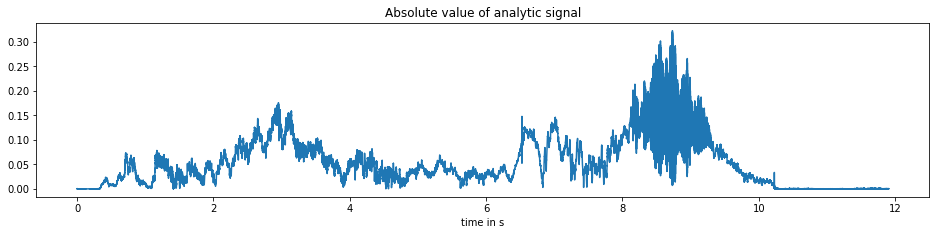

In [10]:
fig1 = figure(figsize=(width,height))
## Your lovely code here:
sig = signal.hilbert(rcv_chirp)
sig_axis = np.r_[0:len(sig)]/fs
width, height = figaspect(0.2)
plt.plot(sig_axis, abs(sig))
plt.title('Absolute value of analytic signal')
plt.xlabel('time in s')


### Part I, Task IV: Auto-correlation Properties of the Chirp:

In part II of the lab, we will be sending and receiving chirp pulses to estimate delays between the tranceived pulses. This is done by cross correlating / matched filtering the received signal with the known chirp pulse to detect the echoes. In this task, we will investigate the correlation properties of the chirp.

A cross correlation is defined as:

$$ R_{xy}[n] = \sum_{m=-\infty}^\infty x[m]y^*[m-n] = (x[m]*y^*[-m])[n]$$

, where $y^*[-m]$ is the complex conjugat of $y[-m]$. This similar to a convolution, without flipping one of the signals. It can be implemented using a convolution as shown above. In general, the more correlated the two signals is at position $n$, the higher the value will be. That's why it is useful in a sonar system.

#### Matched filter 
When we look for a very specific shape in a signal, we can comput a cross correlation between the signal and the shape we are interested in. In that case, the operation of the cross correlation is also called a matched filter -- i.e. correlating with a filter that is matched to the shape we look for. 

Because we will be doing cross-correlations between a chirp pulse and its echoes, it is useful to look at the auto-correlation, which is basically a cross correlation of the signal with itself. A discrete autocorrelation of a signal is defined as: 

$$ R_{xx}[n] = \sum_{m=-\infty}^\infty x[m]x^*[m-n] = (x[m]*x^*[-m])[n]$$ 

The chirp has a very nice property that its auto-correlation is very narrow. Since the spread of the resulting correlation determines how fast you can detect, the width of the auto-correlation is important. This property is called pulse compression and is widely considered in radar design. Random noise and some other pseudo-random like sequences also possess this property. 

* Generate a 512 sample chirp pulse with a frequency sweep from 17KHz-18KHz and sampling rate fs=48000. 
* Validate its frequency response by plotting it.

Text(0.5, 0, 'Frequency in Hz')

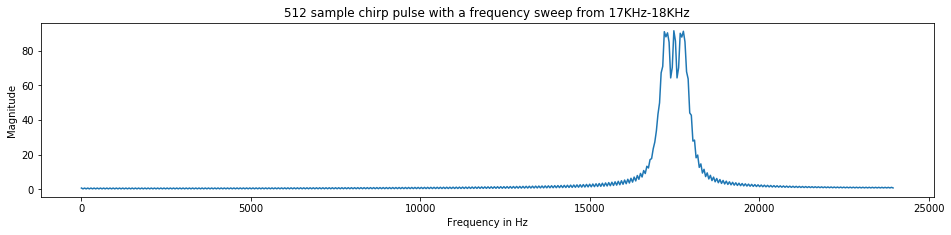

In [44]:
## Your beautiful code here:
# set params
fs = 48000
f0 = 17000
f1 = 18000
n = 512
T = n/fs
# generate time index and phase
t = (1/fs)*np.r_[0:n]
k = (f1-f0)/T
f = f0+k*t
phi_of_t = 2*np.pi*t*(f0+(k/2)*t)
s_chirp = np.sin(phi_of_t)
# generate frequency response of chirp
w,h = signal.freqz(s_chirp)
freq = 0.5*w*fs/np.pi
w = w/np.pi
# plot 
width, height = plt.figaspect(0.2)
fig2 = plt.figure(figsize=(width,height))

plt.plot(freq, abs(h))
plt.title('512 sample chirp pulse with a frequency sweep from 17KHz-18KHz')
plt.ylabel('Magnitude')
plt.xlabel('Frequency in Hz')




* Compute the autocorrelation of the chirp "using" discrete convolution, either with `signal.convolve` or `signal.fftconvolve`. Remember that you have to flip the signal since convolution does that already. You can flip a signal `x` by doing `x[::-1]`. Use mode=''full'' for convolution.
* Plot the autocorrelation. Your plot should be spiky because we did not do envolope detection yet. Use miliseconds as the x-axis

Text(0.5, 0, 'Time in ms')

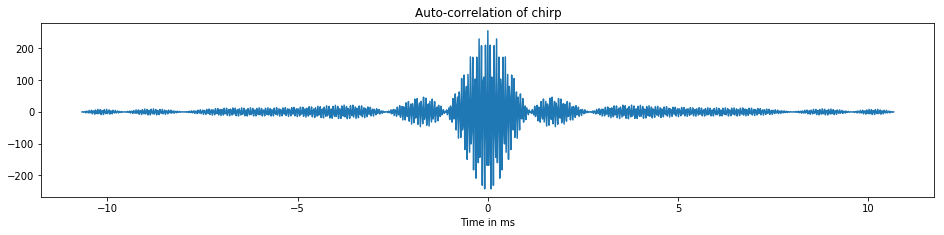

In [48]:
## Your fantastic code here:
auto_chirp = signal.convolve(s_chirp, np.conj(s_chirp[::-1]), mode="full")
x_chirp = np.linspace(-T*1000, T*1000, 2*n-1)

width, height = figaspect(0.2)
fig3 = figure(figsize=(width,height))

plt.plot(x_chirp, auto_chirp)
plt.title('Auto-correlation of chirp')
plt.xlabel('Time in ms')

In a similar way as we did before, it is possible to recover the envelope of the autocorrelation by performing a cross-correlation with the analytic signal and then taking the absolute value. In this case, we know exactly what is the analytic function is!

* Generate `s_chirp_a`, the analytic function of the chirp by computing: `s_chirp_a = exp(1j* phi_of_t )`. Perform cross correlation between `s_chirp_a` and `s_chirp` and show the envelope. As stated before, this could also be called a matched filter. 
* Measure the full-width at half max (FWHM) of the main lobe of the autocorrelation. 
* Comment on the FWHM of the main lobe of the matched-filter with respect to the length of the pulse. That ratio is also called pulse compression.  For simplicity, normalize the plot such that the maximum is 1, but record the maximum value of the autocorrelation and display it in the title of the figure.  

Use the pragma ``%matplotlib notebook`` for making the figure interactive, and ``plt.grid('on')`` for displaying a grid. 

Use miliseconds as the x-axis



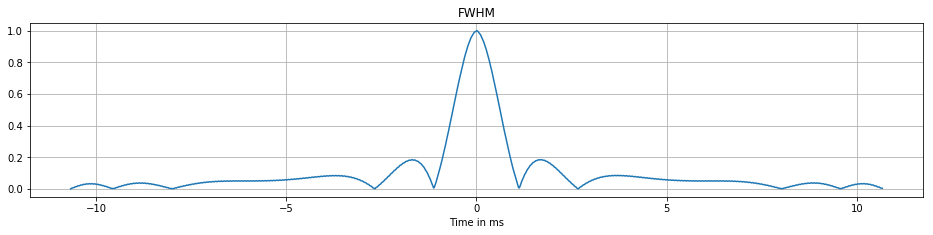

In [46]:
# %matplotlib notebook
# your nice script to produce beautiful chirps, xcorralations and figures here:
%matplotlib inline
s_chirp_a = np.exp(1j* phi_of_t)

Auto_chirp = signal.convolve(s_chirp, np.conj(s_chirp_a[::-1]), mode="full")
x_chirp = np.linspace(-T*1000, T*1000, 2*n-1)

width, height = figaspect(0.2)
fig4 = figure(figsize=(width,height))


plt.plot(x_chirp, abs(Auto_chirp)/np.max(abs(Auto_chirp)))
plt.title('FWHM')
plt.xlabel('Time in ms')
plt.grid('true')


#### Your answer here:
The half of the maximum is around 0.623 ms.
So FWHM = 1.246 ms.
The ratio is n/fs/FWHN = 8.56.
_____

Now we will look at why the chirp pulse is better for cross-correlation detection than a pure tone.
- Repeat Task "III" <- "IV" for:
 1. A constant frequency of 17000Hz, 512 samples in length. 
 2. A chirp with a frequency sweep from 16500Hz - 17500Hz (1KHz Bandwidth), 512 in length.  
 3. A chirp with a frequency sweep from 15000Hz - 19000Hz (4KHz Bandwidth), 512 in length
- Make three subplots in one figure 
- Compare the size of the main lobes (full width at half max). How much "Pulse Compression" are you getting by using a chirps for detection compared to a single frequency pulse?
- What is the approximate bandwidth of the pure frequency pulse and what is the bandwidth of the chirp pulses? Comment on the tradeoff between bandwidth and pulse compression
- What is the maximum autocorrelation for each pulse?


   

255.45886883384938
255.43518472749108
255.34313163945103


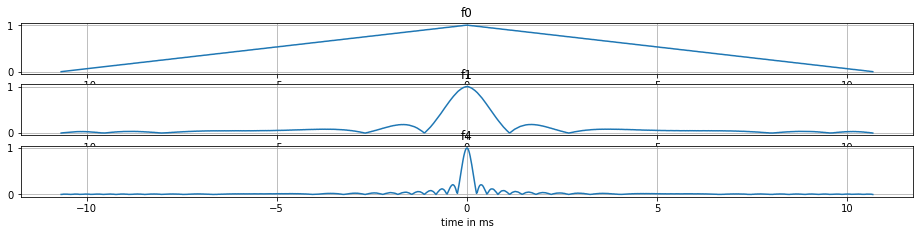

In [49]:
%matplotlib inline
# your solution here
fs = 48000
f0 = 17000
f1_min = 16500
f1_max = 17500
f4_min = 15000
f4_max = 19000
n =512
T = n/fs
t = (1/fs)*np.r_[0:n]

phi_of_t0 = 2*np.pi*(f0*t)
s_chirp_0 = np.sin(phi_of_t0)
x_chirp_0 = signal.convolve(np.exp(1j*phi_of_t0), np.conj(s_chirp_0[::-1]), mode="full")
auto_chirp_0 = signal.convolve(s_chirp_0, s_chirp_0[::-1], mode="full")

phi_of_t1 = 2*np.pi*(f1_min*t+0.5*(f1_max-f1_min)*t*t/T)
s_chirp_1 = np.sin(phi_of_t1)
x_chirp_1 = signal.convolve(np.exp(1j*phi_of_t1), s_chirp_1[::-1], mode="full")
auto_chirp_1 = signal.convolve(s_chirp_1, s_chirp_1[::-1], mode="full")

phi_of_t4 = 2*np.pi*(f4_min*t+0.5*(f4_max-f4_min)*t*t/T)
s_chirp_4 = np.sin(phi_of_t4)
x_chirp_4 = signal.convolve(np.exp(1j*phi_of_t4), s_chirp_4[::-1], mode="full")
auto_chirp_4 = signal.convolve(s_chirp_4, s_chirp_4[::-1], mode="full")
# help with plot
x_cor_axis = np.linspace(-T*1000, T*1000, 2*n-1)
width, height = figaspect(0.2)
fig1, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(width,height))
ax1.plot(x_cor_axis, abs(x_chirp_0)/np.max(abs(x_chirp_0)))
ax1.set_title('f0' )
ax1.set_xlabel('time in ms')
ax1.grid('True')

ax2.plot(x_cor_axis, abs(x_chirp_1)/np.max(abs(x_chirp_1)))
ax2.set_title('f1' )
ax2.set_xlabel('time in ms')
ax2.grid('True')
         
ax3.plot(x_cor_axis, abs(x_chirp_4)/np.max(abs(x_chirp_4)))
ax3.set_title('f4' )
ax3.set_xlabel('time in ms')
ax3.grid('True')


print(np.max(abs(auto_chirp_0)))
print(np.max(abs(auto_chirp_1)))
print(np.max(abs(auto_chirp_4)))

#### Your answers and interpretations here:

1 For chirp_0 is 1,chirp_1 is 8.8,chirp_4 is 35.8


2 The bandwidth of pure tone is 0  
The bandwidth of chirp signal 1 is 1000Hz.  
The bandwidth of chirp signal 2 is 4000Hz.


The bandwidth will increase with the increasing pulse compression.


- Now, repeat task "III" <- "IV" for 
 1. a chirp with a frequency sweep from 15000Hz - 19000Hz, 256 in length
 2. a chirp with a frequency sweep from 15000Hz - 19000Hz, 512 in length

- Make two subplots in one figure 
- Compare the size of the main lobe (full width at half max) to the previous case of  15000Hz - 19000Hz, 512 in length.
- Compare the maximum autocorrelation as well. 

What's the effect of having more bandwidth? what's the effect of having longer/shorter pulses?



127.90772448543606
255.34313163945103


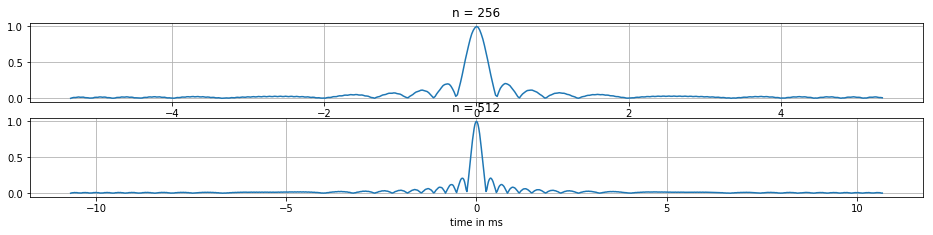

In [15]:
# your solution here

fs = 48000
f0 = 15000
f1 = 19000

n1 = 256
n2 = 512

T1 = n1/fs
T2 = n2/fs

t1 = (1/fs)*np.r_[0:n1]
t2 = (1/fs)*np.r_[0:n2]

phi_of_t1 = 2*np.pi*(f0*t1+0.5*(f1-f0)*t1*t1/T1)
s_chirp_1 = np.sin(phi_of_t1)
x_chirp_1 = signal.convolve(s_chirp_1, np.exp(1j*phi_of_t1)[::-1], mode="full")
auto_chirp_1 = signal.convolve(s_chirp_1, s_chirp_1[::-1], mode="full")
print(np.max(abs(auto_chirp_1)))

phi_of_t2 = 2*np.pi*(f0*t2+0.5*(f1-f0)*t2*t2/T2)
s_chirp_2 = np.sin(phi_of_t2)
x_chirp_2 = signal.convolve(s_chirp_2, np.exp(1j*phi_of_t2)[::-1], mode="full")
auto_chirp_2 = signal.convolve(s_chirp_2, s_chirp_2[::-1], mode="full")
print(np.max(abs(auto_chirp_2)))

x_cor_axis_1 = np.linspace(-T1*1000, T1*1000, 2*n1-1)
x_cor_axis_2 = np.linspace(-T2*1000, T2*1000, 2*n2-1)
width, height = figaspect(0.2)
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(width,height))

ax1.plot(x_cor_axis_1, abs(x_chirp_1)/np.max(abs(x_chirp_1)))
ax1.set_title('n = 256')
ax1.set_xlabel('time in ms')
ax1.grid('on')

ax2.plot(x_cor_axis_2, abs(x_chirp_2)/np.max(abs(x_chirp_2)))
ax2.set_title('n = 512')
ax2.set_xlabel('time in ms')
ax2.grid('on')

####  Your answer below:
Question1: 
The increase bandwidth make the FWHM narrower 
Also, the pulse compression is higher if the bandwidth increase.

Question2: 


n=256

maximum autocorrelation=127.90772448543606

n=512

maximum autocorrelation=255.34313163945103

### Dealing with sidelobes
As you can see, the chirp provides good pulse compression of the main-lobe. However, there exists very strong sidelobes. This is because the chirp is multiplied with a rect function, that is abrupt. Instead, we will window the chirp with one of the smooth window functions to taper off the sidelobes. 
    

* Repeat the above for a chirp with a sweep from 16.5KHz to 17.5KHz, and from 15KHz to 19KHz. This time, multiply the chirp (and its analytic function) with a hanning window.  You will find the function `np.hanning` useful. 

* plot the normalized autocorrelations (in the same figure) 
* Comment on the magnitude of the side-lobes? 
* Comment on the width of the main lobes? 
* What's the tradeoff?


95.81249999954298
95.81249999682203


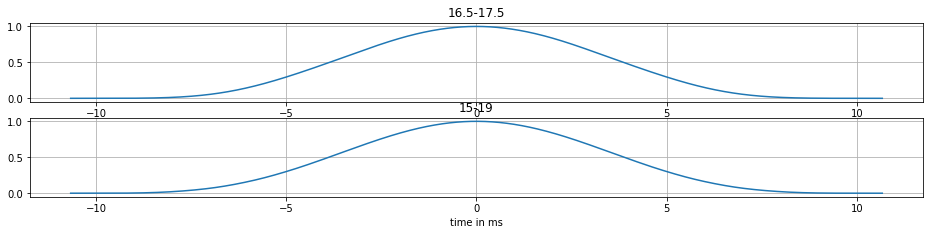

In [52]:
# your solution here

f_diff0 = 1000
f_diff1 = 4000
fs = 48000
n = 512
T = n/fs
t = (1/fs)*np.r_[0:n]

phi_of_t0 = 2*np.pi*(16500*t+0.5*(f_diff0)*t*t/T)
phi_of_t1 = 2*np.pi*(15000*t+0.5*(f_diff1)*t*t/T)

window = np.hanning(512)

s_chirp_0 = np.sin(phi_of_t0)
s_chirp_0_window = s_chirp_0*window
x_chirp_0 = signal.convolve(s_chirp_0_window, np.exp(1j*phi_of_t0)*window[::-1], mode="full")
auto_chirp_0 = signal.convolve(s_chirp_0_window, s_chirp_0_window[::-1], mode="full")
print(np.max(abs(auto_chirp_0)))


s_chirp_1 = np.sin(phi_of_t1)
s_chirp_1_window = s_chirp_1*window
x_chirp_1 = signal.convolve(s_chirp_1_window, np.exp(1j*phi_of_t1)*window[::-1], mode="full")
auto_chirp_1 = signal.convolve(s_chirp_1_window, s_chirp_1_window[::-1], mode="full")
print(np.max(abs(auto_chirp_1)))

x_cor_axis = np.linspace(-1000*T, 1000*T, 2*n-1)

width, height = figaspect(0.2)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(width,height))

ax1.plot(x_cor_axis, abs(x_chirp_0)/np.max(abs(x_chirp_0)))
ax1.set_title('16.5-17.5')
ax1.set_xlabel('time in ms')
ax1.grid('on')

ax2.plot(x_cor_axis, abs(x_chirp_1)/np.max(abs(x_chirp_1)))
ax2.set_title('15-19')
ax2.set_xlabel('time in ms')
ax2.grid('on')


#### Your answers here:

If we double the width of the main lobe, the maximum autocerrleation would get reduced. 

### You are now ready to proceed to the Sonar Lab

## Part 2: Sonar

In this part of the lab we will write a simple application that implements a sonar using the laptop internal speaker and microphone. 

The basic idea is very simple and is the basis of sonar and ultrasound images -- Objects reflect sound waves. If we send a pulse of sound, we will get reflection echoes of that pulse. Detecting the echos and their time-of-flight will reveal their distance from the source, based on the speed of sound in air. 

The way we are going to implement the sonar is to generate a series of rapid pulses, and use matched filtering to detect the source and the returning echos. There are many parameters in this lab that can be tweaked to get different results. We encourage you to experiment. We hope you enjoy this. 


#### Instructions for laptops:

Unfortunately, the quallity of the sonar system is going to be highly dependent on your laptop quallity, and the position of the speakers and microphone. It is recommended that you adjust the sound settings on your system such that only the speaker that is closer to the microphone is active. For example, MacBookAirs have the microphone on the side of the computer -- so you should set adjust the audio settings to left speaker only. Also, it is recommended that the speaker volume be set to half of its maximum to avoid non-linear distortions.  

If you are getting poor results, please consult with us. 






### Part II, Task I: Generating Chirp Pulses

Recall from Part I, that the with of the main lobe of the autocorrelation depends on the bandwidth of the pulse. 
For a constant frequency pulse, the bandwidth will be inversly proportional to its length. Short pulses are localized in time, and therefore we will be able to separate echoes from targets that are close. However, short pulses carry less energy (for the same amplitude) and this will reduce our signal to noise ratio (SNR) in the detection and reduce our ability to detect the targets at all. So, in summary: for constant frequency pulse, there's an inerent tradeoff between the resolution of the sonar (distinguish between close targets) and the signal to noise ratio. 

If we use a chirp pulse, we can increase the length of the pulse while also increasing the bandwidth. This will enable us to improve our signal to noise ratio as well as keeping the resolution of our sonar (by preserving the BW).

In our implemetation we are going to design a pulsed sonar system in which we repeatedly send pulses and then listen to the returning echoes. The arrival time of the echos will correspond to double the time-of-flight of sound propagation from our system to the target. 

* Write a function that generates a chirp pulse:
`pulse = genChirpPulse(Npulse, f0, f1, fs)` 

The function will accept: `Npulse` = number of samples, `f0,f1` = starting and ending frequency and `fs` = sampling frequency. The function will return the analytic function of the chirp $\exp (j 2\pi \int_0^t f(t)dt )$ with amplitude 1.

In [17]:
def genChirpPulse(Npulse, f0, f1, fs):
    #     Function generates an analytic function of a chirp pulse
    #     Inputs:
    #             Npulse - pulse length in samples
    #             f0     - starting frequency of chirp
    #             f1     - end frequency of chirp
    #             fs     - sampling frequency
    #     Output:
    #              pulse - chirp pulse
    n = Npulse
    T = n/fs
    # generate time index and phase
    t = (1/fs)*np.r_[0:n]
    k = (f1-f0)/T
    f = f0+k*t
    phi_of_t=2*np.pi*t*(f0+(k/2)*t)
    # generate chirp signal
    s_chirp = 1j*np.sin(phi_of_t)+np.cos(phi_of_t)
    return s_chirp    


* To validate that the function works display the pulse generated with Npulse = 200, f0=1000, f1 = 8000, fs = 48000. Remember the pulse is complex, so plot the real and imaginary part separately.

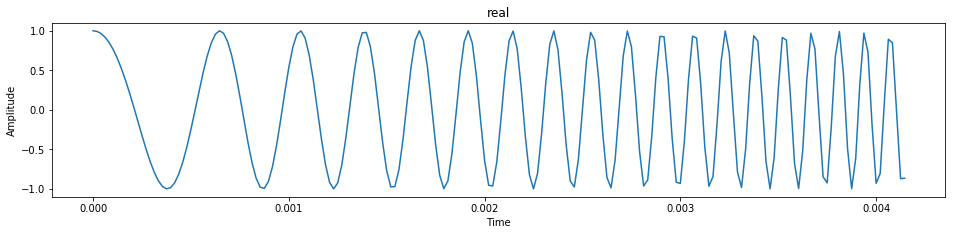

<Figure size 432x288 with 0 Axes>

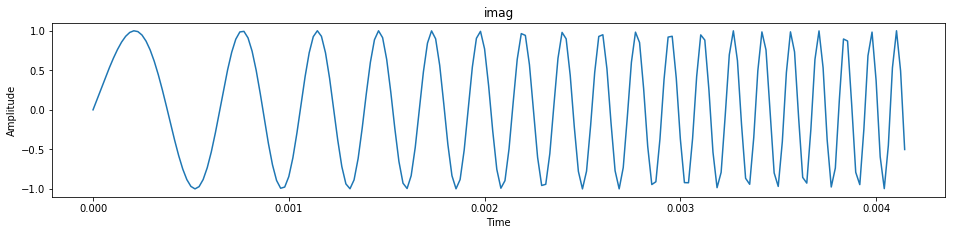

Text(0.5, 0, 'Frequency in Hz')

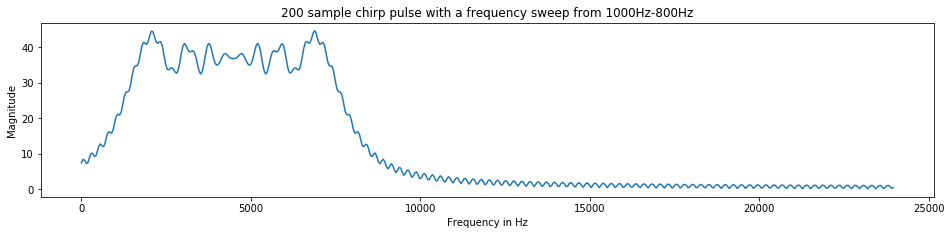

In [18]:
%matplotlib inline
# parameter
Npulse=200
f0=1000
f1=8000
fs=48000
t= 1/fs*np.r_[0:Npulse]
# print(len(t))

pulse = genChirpPulse(Npulse, f0, f1, fs)
real_component = pulse.real
imag_component= pulse.imag

width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plot(t,real_component)
plt.title('real')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

plt.figure()
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plot(t,imag_component)
plt.title('imag')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()



# #___________________________________________________________________
w,h = signal.freqz(pulse)
freq = 0.5*w*fs/np.pi
w = w/np.pi
# plot 
width, height = plt.figaspect(0.2)
fig2 = plt.figure(figsize=(width,height))
plt.plot(freq, abs(h))
plt.title('200 sample chirp pulse with a frequency sweep from 1000Hz-800Hz')
plt.ylabel('Magnitude')
plt.xlabel('Frequency in Hz')

# recieving_pulse = xciever(np.real(pulse), fs)

__Generate Pulse Trains__

Next, we will use the pulse generated by `genChirpPulse` and generate a pulse train.

* Write a new function `ptrain = genPulseTrain(pulse, Nrep, Nseg)`
The function accepts `pulse` = a pulse generated by `genChirpPulse`,  `Nrep` = number of pulse repetitions and `Nseg` = length of each pulse train segment (which is >= to the length of `pulse`).

The function returns `ptrain` which is a vector of length `Nrep` x `Nseg` (Hint: use `np.tile`)

In [19]:
def genPulseTrain(pulse, Nrep, Nseg):
    # Funtion generates a pulse train from a pulse. 
    #Inputs:
    #    pulse = the pulse generated by genChirpPulse
    #    Nrep  =  number of pulse repetitions
    #    Nseg  =  Length of pulse segment >= length(pulse)
    seg = np.append(pulse, np.zeros(Nseg - len(pulse)))
#     print(len(pulse))
#     print(len(np.zeros(Nseg - len(pulse))))
    return np.tile(seg, Nrep)



### Part II, Task II: Echos in with Chirp pulse train

We now have components to generate pulses, generate a pulse train, play and record it. Lets see what we get!
We will start with very short pulses with a single carrier frequency. Rectangular pulses are difficult for the speaker
to produce as they exhibit discontinuities in the beginning and the end of the pulse. Therefore we will multiply the pulses
with a smooth window. Here, we will use a hanning window.

* Generate a f0=f1=8KHz, Npulse=96 pulse with fs=48000. Window the pulse with a hanning window. This will result in a pulse length of 2ms. You should be able to hear this tone.
* Plot the real and imaginary part of the pulse

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


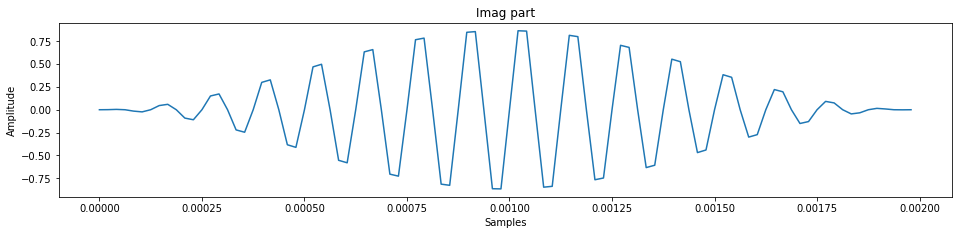

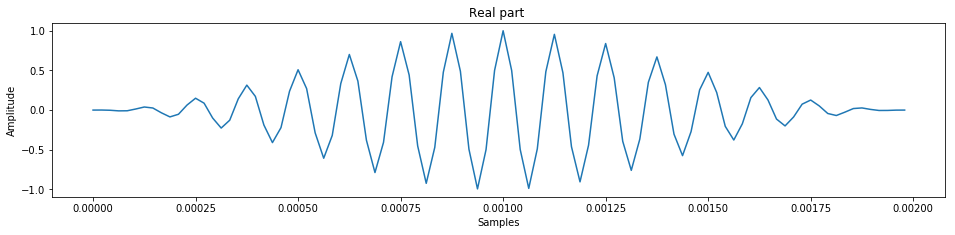

In [230]:
%matplotlib inline
fs = 48000
f0 = 8000
f1 = 8000
Npulse = 96

# your code here:

pulse = genChirpPulse(Npulse, f0, f1, fs)*np.hanning(Npulse)
rcv = xciever(pulse,fs) 
t=np.r_[0:Npulse]*1/fs

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Imag part")
plt.plot(t, np.imag(pulse))


width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("Real part ")
plt.plot(t, np.real(pulse))



* Use the real part of the pulse to generate a pulse train of Nrep=15 pulses, Nseg=4096 samples

In [278]:
Nrep=15
Nseg=4096
trained_pulse = genPulseTrain(np.real(pulse_a), Nrep, Nseg)


* Play and record the pulse train. Scale the amplitude of the pulses to 1/2. Make sure your volume is set to maximum of 70% and look at the plot with the input pulse train and the received pulse train.

Use the pragma ``%matplotlib notebook`` for interactive plots, so you can zoom into the result.

In [252]:
rcv = xciever(trained_pulse/2.0 , fs) 
#we got 15 sounds,correct!

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


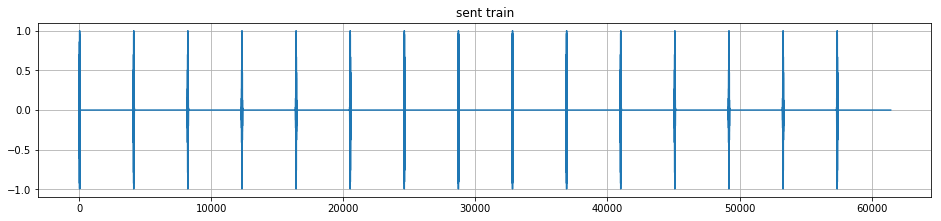

<Figure size 432x288 with 0 Axes>

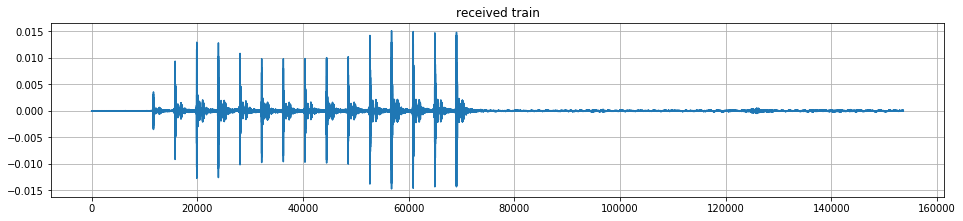

In [302]:
#  %matplotlib notebook
%matplotlib inline
fs = 48000
Npulse = 96
t= 1/fs*np.r_[0:Nseg*Nrep]
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot(trained_pulse)
plt.title('sent train')
plt.grid('true')
plt.figure()
width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.plot(rcv)
plt.title('received train')
plt.grid('true')

* Extract a single pulse from the received pulse train. You can find the pulse index from the interactive plot. Extract at least 2 Npulse samples before the pulse and 20 Npulse samples after using `rcv_pulse = rcv[idx-2*Npulse:idx+Npulse*20]` 

* Plot the received pulse. Can you see any echoes?

You can disable interactivity by the pragma ``matplotlib inline``


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


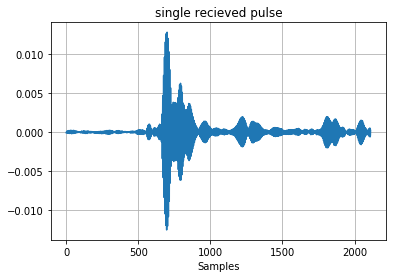

In [285]:
%matplotlib inline
idx =4096*5+3000
rcv = xciever(trained_pulse/2.0 , fs) 
rcv_pulse = rcv[idx-2*Npulse:idx+Npulse*20]
plt.plot(rcv_pulse)
plt.title('single recieved pulse')
plt.xlabel('Samples')
plt.grid('on')




#### Matched Filtering

The strong pulses we see are a result of direct feed-through from the transmitter to the receiver that do not scatter off targets. The echoes we see are a result of echoes from reflecting surfaces. The problem in our setup is that we don't know the exact delay between the transmitter and the receive hardware (in PyAudio). Instead, we will assume that the travel time for sound between the speaker and the microphone is negligible and much smaller than scatering targets. We can then detect when the pulses start based on the direct feedthrough signal. This assumption is very good as long as your speaker is close to the microphone!

We will detect both the feedthrough and echoes using matched filtering. 

* Write a function `Xrcv = crossCorr( rcv, pulse_a )` to calculate the cross correlation (matched filter) of the received signal with the analytic function of the pulse.  You can use `signal.fftconvolve`
* Take the absolute value of `Xrcv` to recover its envelope. Call the result `Xrcv_a`.

Make sure the plot is interactive with ``matplotlib notebook``

In [283]:
def crossCorr( rcv, pulse_a ):
    # Funtion generates cross-correlation between rcv and pulse_a
    # Inputs:
    #    rcv - received signal
    #    pulse_a - analytic pulse
    # Output:
    #    Xrcv - cross-correlation between rcv and pulse_a
    return signal.convolve(rcv, pulse_a[::-1])

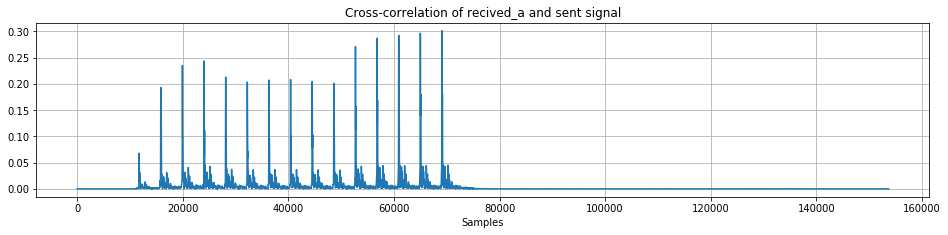

In [284]:
Xrcv = crossCorr(rcv, pulse_a)
Xrcv_a = abs(Xrcv)

width, height = figaspect(0.2)
fig2 = figure(figsize=(width,height))
plt.plot(Xrcv_a)
plt.title('Cross-correlation of recived_a and sent signal')
plt.xlabel('Samples')
plt.grid('on')


* Again, extract a single pulse from the received pulse train using the same index. Extract at least 2 Npulse samples before the pulse and 20 Npulse samples after. Plot the received pulse. Can you see any echoes?

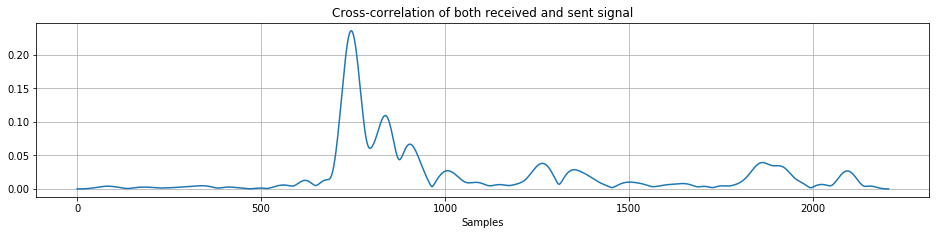

In [286]:
pulse = pulse_a[idx-2*Npulse:idx+Npulse*20]
Xrcv_pulse = crossCorr(rcv_pulse, pulse_a)
width, height = figaspect(0.2)
fig2 = figure(figsize=(width,height))

plt.plot(abs(Xrcv_pulse))
plt.title('Cross-correlation of both received and sent signal')
plt.xlabel('Samples')
plt.grid('on')


#### Sonar System

In order to automate the system and visualize the results we need a few more components. To extract the pulses we need to know the position of the first feedthrough pulse. 


* Write a function `idx = findDelay(Xrcv_a, Nseg)` that takes the result of the matched filtering and finds the index of the first feedthrough pulse. Try testing on the actual signal to check whether the function is correct. There are multiple ways of doing it. `Nseg` is not necessarily required.

In [303]:
def findDelay(Xrcv, Nseg):
    # finds the first pulse
    # Inputs:  
    #         Xrcv - the received matched filtered signal
    #         Nseg - length of a segment
    # Output:
    #          idx - index of the beginning of the first pulse
    
    result =np.max(abs(Xrcv))*0.9

    idx=np.argmax(abs(Xrcv)>result)
  
    
    return idx

In [307]:
idx = findDelay(Xrcv_a,Nseg)

print(56813*1/fs)


1.1836041666666666


We now can correct for delays and detect echoes. The only thing left now is to convert the time between echoes into actual distance.

If we send a pulse of sound, we will get reflection echoes of that pulse. Detecting the echos and their time-of-flight will reveal their distance from the source, based on the speed of sound in air. The speed of sound in air is given by the following equation:

$$ v_s = 331.5\sqrt{1+T/273.15}~\mathrm{m/s}~,$$ 

where T is the temperature in degree celcius. 

* Create a function `t = dist2time( dist, temperature )` that takes in the distance to the target in cm and converts it into the time in seconds between the transmitted pulse and its echo. Remember the arrival time include the time to the target and back and therefore the time should be doubled. 
For example, for temperature = 20 celcius and dist = 400 cm, the time it takes is 0.023 secs.

* Create a function `dist = time2dist( t, temperature )` that takes in the time to the target in seconds and converts it into the distance in cm between the transmitted pulse and its echo. Remember the arrival time include the time to the target and back and therefore the time should be halfed. 

In [32]:
def dist2time( dist, temperature=21):
    # Converts distance in cm to time in secs
    # Inputs:
    # dist        - distance to object in cm
    # temperature - in celcius
    # Output:
    # t           - time in seconds between transmitted pulse and echo
    
    Vs = 331.5*np.sqrt(1+temperature/273.15)
    dist_IN_sec = 2*dist/100
    
    return dist_IN_sec/Vs
 

def  time2dist(t,temperature=21):
    # Converts time in seconds to distance in cm
    # Inputs:
    # t        - time of echo
    # temperature - in celcius
    # Output:
    # dist          - distance in cm of the target
    
    Vs = 331.5*np.sqrt(1+temperature/273.15)
    
    dist_IN_cm = Vs*t*100/2
    return dist_IN_cm
 

In [33]:
t = dist2time(400, 20)
print(t)

dist = time2dist(t, 20)
print(dist)

0.02329496742157036
400.0


## A sonar (almost)

* The following function will use your functions to generate pulses and display the matched filtering of each pulse as intensity of a horizontal line in an image. If nothing is moving, you will be able to see constant vertical lines representing echos. If something is moving, you will be able to track the object's distance.  



In [287]:
# some code for you

def sortOfASonar(Npulse, f0, f1,fs, Nrep, Nseg):
    pulse_a = genChirpPulse(Npulse, f0, f1, fs)
    hanWin = np.hanning(Npulse)
    hanWin = np.reshape(hanWin, (Npulse,1))
    pulse_a = np.multiply(pulse_a,hanWin)
    pulse = np.real(pulse_a)
    ptrain = genPulseTrain(pulse, Nrep, Nseg)
    rcv = xciever(ptrain/2.0 , fs) 
    Xrcv_a = abs( crossCorr(rcv, pulse_a) )
    Xrcv_a = np.reshape(Xrcv_a, (1,len(Xrcv_a)))
    
    idx = findDelay(Xrcv_a,Nseg) 
    img = np.zeros((Nrep,Nseg))
    img[0,:] = Xrcv_a[0,idx:idx+Nseg]
    
    # Look for peak in each pulse in the pulse train to avoid drift between xmit and receive
    for n in range(1,Nrep):
        idxx = findDelay(Xrcv_a[0,idx+int(Nseg/2):idx+int(Nseg/2)+Nseg],Nseg)
        idx = idx + idxx + int(Nseg/2)
        img[n,:]=Xrcv_a[0,idx:idx+Nseg]
        
    
    return img


Now, use the function above to:  

* Generate a pulse train of 100 pulses. Each (hamming windowed) pulse should be length of 72 samples (1.5ms) and constant frequency of 8KHz. The spacing between puslses should be 0.1 seconds (Nseg=4800). 
* Display the image

In [308]:
def crossCorr(rcv, pulse_a):
    # Funtion generates cross-correlation between rcv and pulse_a
    # Inputs:
    #    rcv - received signal
    #    pulse_a - analytic pulse
    # Output:
    #    Xrcv - cross-correlation between rcv and pulse_a
    pulse_a = pulse_a.reshape(len(pulse_a)*len(pulse_a[0]),1)
    rcv = rcv.reshape(len(rcv),1)
    return signal.convolve(rcv, pulse_a[::-1])

In [309]:
Npulse = 72
f0 = 8000
f1 = 8000
fs = 48000
Nrep = 100
Nseg = 4800

img = sortOfASonar(Npulse, f0, f1,fs, Nrep, Nseg)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


ValueError: could not broadcast input array from shape (3564) into shape (4800)

Display the result. Pay attention to the width of the echos. 

Text(0, 0.5, 'sec')

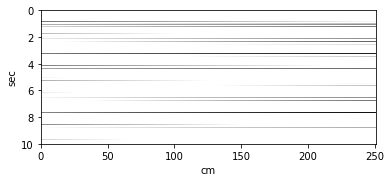

In [37]:


# display up to 2.5m approximately 700 samples at 21 degrees C in 48000 sampling rate

vmax = 0.3 # threshold -- lower will be able to see smaller echos

plt.imshow(img[:,0:700]/max(img.ravel()),vmax=vmax, aspect=10,cmap='gray',interpolation='bilinear',extent=(0,time2dist(700/48000),Nrep*Nseg/fs,0))
plt.xlabel('cm')
plt.ylabel('sec')

Now, repeat the experiment with a chirp length of Nseg = 360 samples, and a frequency sweep from 6KHz to 12KHz.
Pay attention to the resolution of the lines. 

In [ ]:
Npulse = 72*5
f0 = 6000
f1 = 12000
fs = 48000
Nrep = 100
Nseg = 4800
img = sortOfASonar(Npulse, f0, f1,fs, Nrep, Nseg)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [ ]:


# display up to 2.5m approximately 700 samples at 21 degrees C in 48000 sampling rate

vmax = 0.3 # threshold -- lower will be able to see smaller echos

plt.imshow(img[:,0:700]/max(img.ravel()),vmax=0.2, aspect=10,cmap='gray',interpolation='bilinear',extent=(0,time2dist(700/48000),Nrep*Nseg/fs,0))


Feel free to repeat while moving a target-- can you see the echoes changing? Try playing with different parameters. 




## A Real (time) Sonar
You now have a working sonar! It would be much easier though to play with different parameters if we automate things, so we created some wrappers for real-time plotting in a separate notebook (lab1-RealTime-Sonar). 

* Copy-and-paste the 5 functions you created, including genPulseTrain(), genChirpPulse(), crossCorr(), findDelay(), and dist2time(), to the specified code cell in the real-time Sonar lab.


### You are now ready to proceed to the Real-Time Sonar Lab